In [1]:
import torch
import sys  
import os 
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).parent))


from models.deeplabv3_model import DeepLabV3

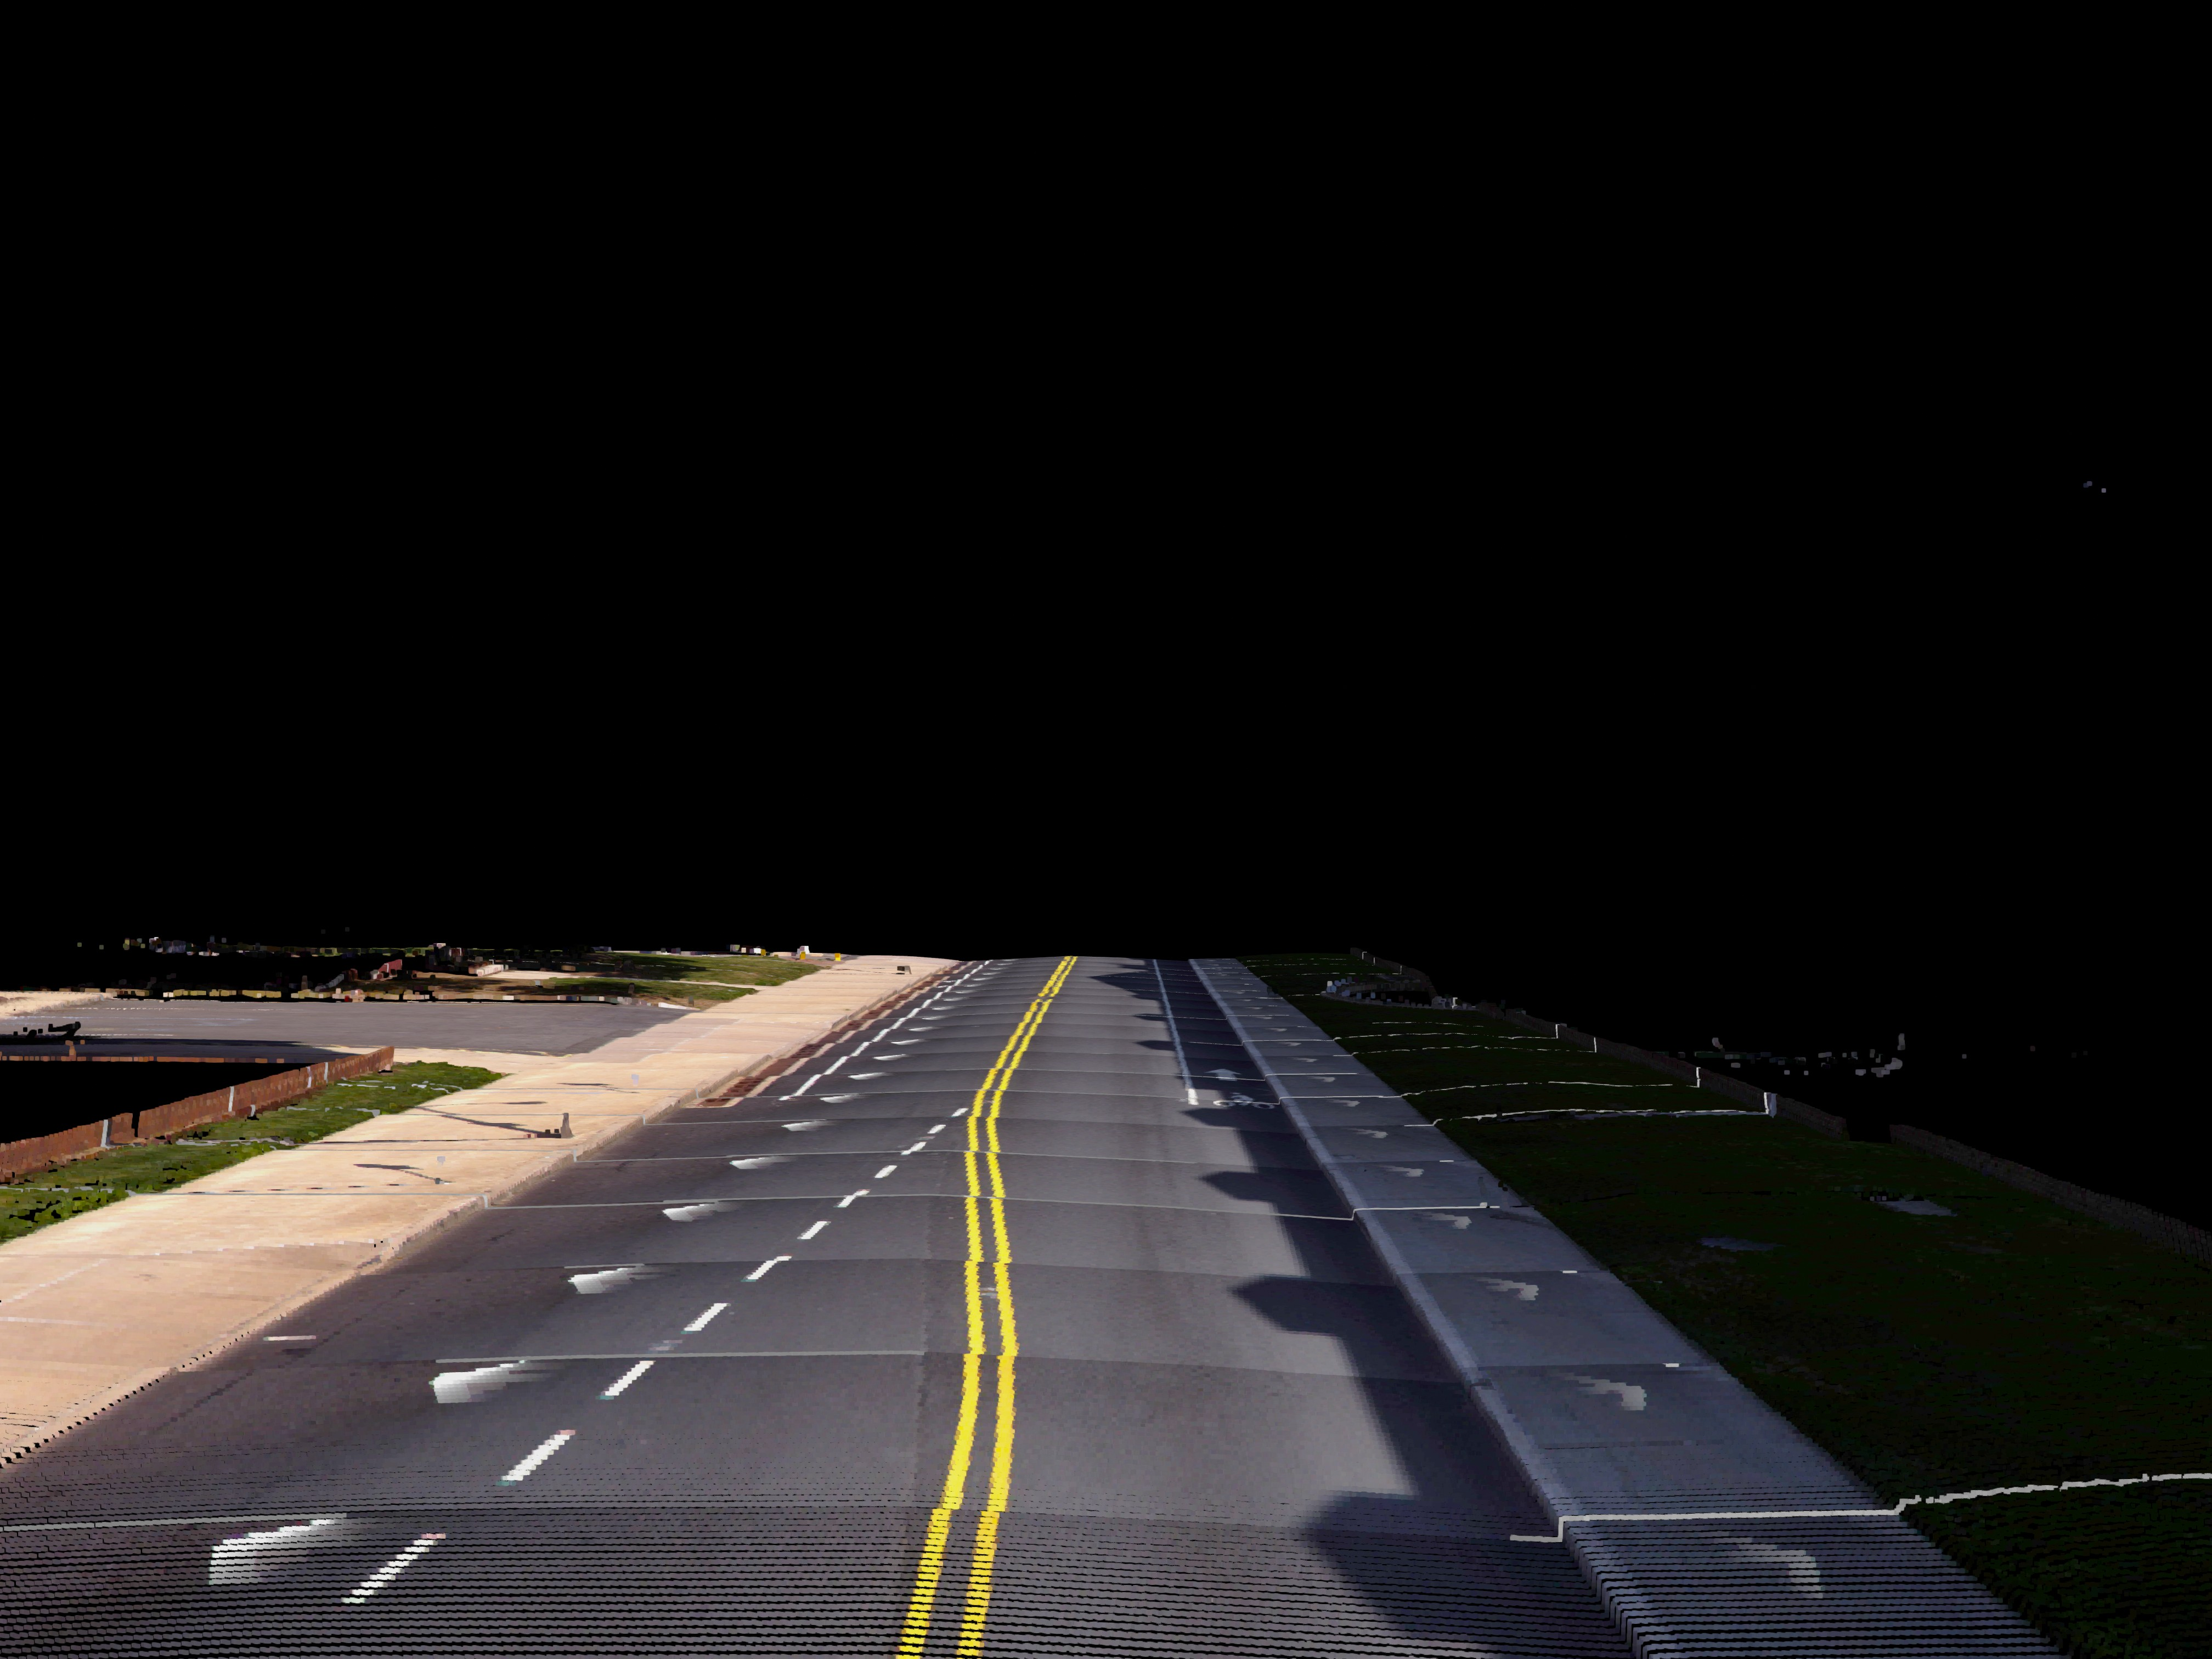

In [29]:
from PIL import Image


test_img_path = "../data/sidewalk/JPEGImages/0711p2.part12.street13b.jpg"
# test_img_path = "../data/sidewalk/JPEGImages/0711p2.part12.1_112_rgb.jpg"

test_img = Image.open(test_img_path)
test_img

In [10]:
model = DeepLabV3.load_from_checkpoint("../checkpoint/v2_augment_sidewalk_deeplabv3_epoch_50/epoch=12-val_loss=3.4627-val_mean_iou=0.0956.ckpt")

In [16]:
import matplotlib.pyplot as plt
def show_img(img_tensor):
    img_np = img_tensor.permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(img_np)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.float32


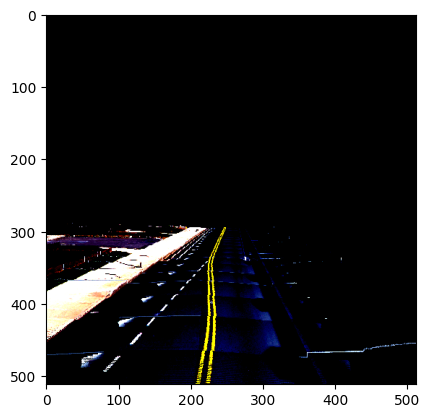

In [30]:
from torchvision.transforms import transforms as T
import albumentations as A
import cv2
import numpy as np


# transform = T.Compose([T.Resize((512, 512)), T.ToTensor()])
device = "cuda" if torch.cuda.is_available() else "cpu"

# img_tensor = transform(test_img).to(device)
# b_img_tensor = img_tensor.unsqueeze(0)

# img_tensor.shape, b_img_tensor.shape, img_tensor.device, b_img_tensor.device


img_resize_transform = A.Resize(512, 512, interpolation=cv2.INTER_LINEAR)
img_nor_transform = A.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

img_pil = Image.open(test_img_path).convert("RGB")
img_np = np.array(img_pil)
img_resize = img_resize_transform(image=img_np)["image"]
img = img_nor_transform(image=img_resize)["image"]
img_tensor = torch.tensor(np.transpose(img, (2, 0, 1)), device=device)
b_img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.shape, img_tensor.dtype)
show_img(img_tensor)

In [31]:
model.eval()
output = model(b_img_tensor)
out = output['out']
out_aux = output['aux']
# out.shape, out_aux.shape
out_img = out.argmax(1)
print(out_img.shape)
torch.unique(out_img), torch.unique(out_aux.argmax(1))

torch.Size([1, 512, 512])


(tensor([0], device='cuda:0'),
 tensor([ 0,  1,  3,  4,  6,  7,  8, 10, 13, 14, 15, 16, 18, 21, 22, 23],
        device='cuda:0'))

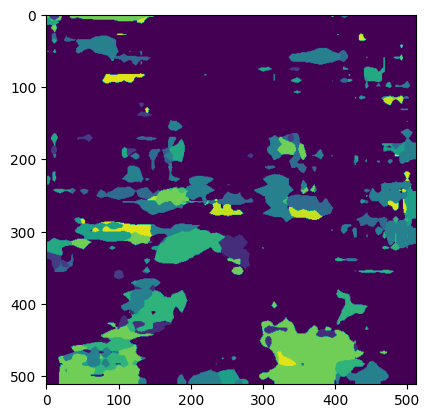

In [32]:
out_aux_mask = out_aux.argmax(1)
out_aux_mask_np = out_aux_mask.squeeze().detach().cpu().numpy()
plt.imshow(out_aux_mask_np)



In [9]:
out_img_np = out_img.squeeze().detach().cpu().numpy()
out_img_np.shape, np.unique(out_img_np)

((512, 512), array([0], dtype=int64))

In [17]:
out[:, 2, :, :]

tensor([[[-0.2373, -0.2373, -0.2373,  ..., -0.1057, -0.1057, -0.1057],
         [-0.2373, -0.2373, -0.2373,  ..., -0.1057, -0.1057, -0.1057],
         [-0.2373, -0.2373, -0.2373,  ..., -0.1057, -0.1057, -0.1057],
         ...,
         [-0.1077, -0.1077, -0.1077,  ..., -0.2037, -0.2037, -0.2037],
         [-0.1077, -0.1077, -0.1077,  ..., -0.2037, -0.2037, -0.2037],
         [-0.1077, -0.1077, -0.1077,  ..., -0.2037, -0.2037, -0.2037]]],
       device='cuda:0', grad_fn=<SliceBackward0>)

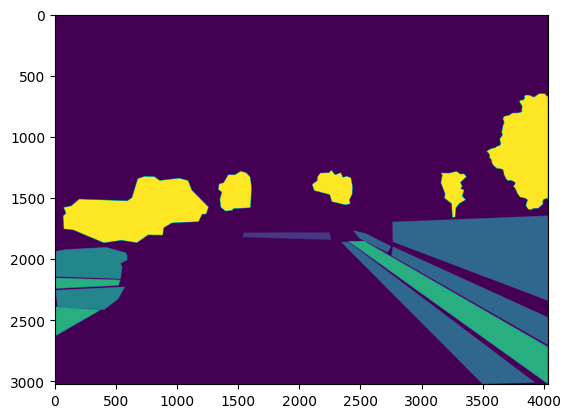

In [90]:
check_img_path = "../data/sidewalk/SegmentationMask/0711p2.part12.4_112_intensity.png"

# check_img = Image.open(check_img_path).convert("L")
check_img = Image.open(check_img_path)
check_img_np = np.array(check_img)

# np.unique(check_img)

plt.imshow(check_img_np)

In [26]:
import torchmetrics

mean_iou_metric = torchmetrics.JaccardIndex(num_classes=25, ignore_index=255, task="multiclass", average="micro")

In [32]:

new_trans = T.Compose([T.ToTensor()])

check_img_tensor = new_trans(check_img).squeeze(0)
pred = torch.zeros(check_img_tensor.shape)

mean_iou_metric(pred, check_img_tensor)

tensor(1.)

In [33]:
check_img_tensor

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.0588, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0588, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [35]:
import cv2 
import albumentations as A

mask = cv2.imread(check_img_path, cv2.IMREAD_GRAYSCALE)

[ 0  4  8 11 15 24]


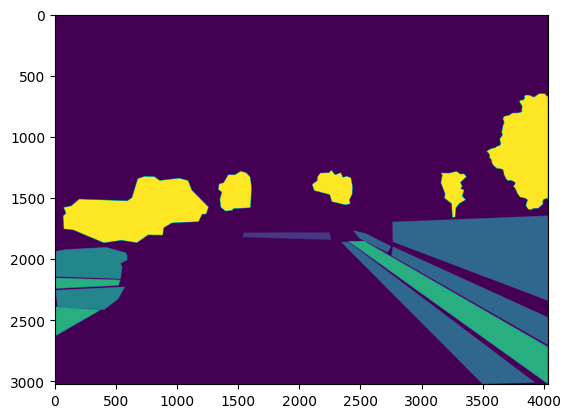

In [45]:
print(np.unique(mask))

plt.imshow(mask)

[ 0  4  8 11 15 24]
torch.Size([256, 256])
torch.int64


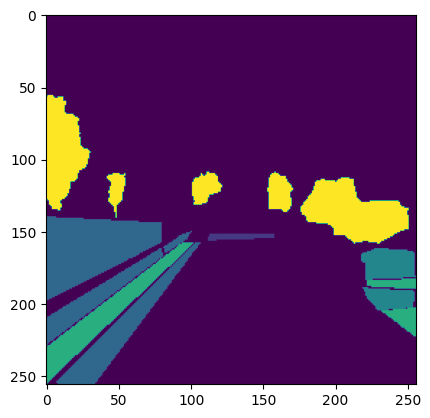

In [94]:
import cv2 
import albumentations as A

mask = cv2.imread(check_img_path, cv2.IMREAD_GRAYSCALE)
print(np.unique(mask))
aug = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), 
    A.HorizontalFlip(p= 0.5), 
    A.VerticalFlip(p= 0.5),
    A.RandomRotate90(p= 0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
])
augmented = aug(image=mask)
aug_mask = augmented['image']

aug_mask_tensor = torch.tensor(aug_mask).long()
print(aug_mask_tensor.shape)
print(aug_mask_tensor.dtype)
# print(aug_mask.shape)
# print(np.unique(aug_mask))
plt.imshow(aug_mask)


In [95]:
aug_mask_tensor

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [15, 15, 15,  ...,  0,  0,  0],
        [15, 15,  0,  ...,  0,  0,  0],
        [15,  0,  0,  ...,  0,  0,  0]])